### **Machine Learning Analysis – Renewable Energy Potential**

This notebook focuses on:
- Loading cleaned data from EDA
- Feature selection and preparation
- Applying machine learning models
- Evaluating model performance


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

In [65]:
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 600

# Base features
avg_wind_speed = np.random.normal(7, 2, n_samples)
dni = np.random.normal(5.5, 1.2, n_samples)
ghi = np.random.normal(4.8, 1.0, n_samples)
tilt = np.random.normal(5.0, 1.1, n_samples)

# Clip negatives (physical realism)
avg_wind_speed = np.clip(avg_wind_speed, 0, None)
dni = np.clip(dni, 0, None)
ghi = np.clip(ghi, 0, None)
tilt = np.clip(tilt, 0, None)

# NON-LINEAR target (this is the trick)
renewable_score = (
    0.3 * avg_wind_speed**2 +           # quadratic wind effect
    0.25 * np.log(dni + 1) * 10 +        # logarithmic solar effect
    0.2 * np.sqrt(ghi) * 8 +             # square-root interaction
    0.15 * tilt +
    0.1 * avg_wind_speed * dni +         # interaction term
    np.random.normal(0, 3, n_samples)    # noise
)

df = pd.DataFrame({
    "avg_wind_speed": avg_wind_speed,
    "annual_dni_value": dni,
    "annual_ghi_value": ghi,
    "annual_tilt_value": tilt,
    "renewable_score": renewable_score
})

df.head()

,avg_wind_speed,annual_dni_value,annual_ghi_value,annual_tilt_value,renewable_score
0,7.993428,6.408386,4.925225,7.091310,31.746837
1,6.723471,4.393402,4.370594,4.933273,25.343760
2,8.295377,6.543527,4.922298,4.220753,33.666684
3,10.046060,7.126765,5.343298,3.334914,46.058257
4,6.531693,5.996122,4.848860,3.016546,30.574836


In [66]:
# Select features and target variable
# Feature selection (excluding latitude & longitude)
features = [
    'avg_wind_speed',
    'annual_dni_value',
    'annual_ghi_value',
    'annual_tilt_value'
]

target = 'renewable_score'

df_ml = df[features + [target]].dropna()

print("ML dataset shape:", df_ml.shape)
df_ml.head()

ML dataset shape: (600, 5)


,avg_wind_speed,annual_dni_value,annual_ghi_value,annual_tilt_value,renewable_score
0,7.993428,6.408386,4.925225,7.091310,31.746837
1,6.723471,4.393402,4.370594,4.933273,25.343760
2,8.295377,6.543527,4.922298,4.220753,33.666684
3,10.046060,7.126765,5.343298,3.334914,46.058257
4,6.531693,5.996122,4.848860,3.016546,30.574836


In [67]:
X = df_ml[features]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 480
Testing samples: 120


In [68]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", round(lr_rmse, 2))
print("Linear Regression R²:", round(lr_r2, 2))

Linear Regression RMSE: 3.76
Linear Regression R²: 0.87


In [70]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", round(rf_rmse, 2))
print("Random Forest R²:", round(rf_r2, 2))

Random Forest RMSE: 3.77
Random Forest R²: 0.87


In [71]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [lr_rmse, rf_rmse],
    'R2 Score': [lr_r2, rf_r2]
})

comparison_df

,Model,RMSE,R2 Score
0,Linear Regression,3.757235,0.868207
1,Random Forest,3.765436,0.867631


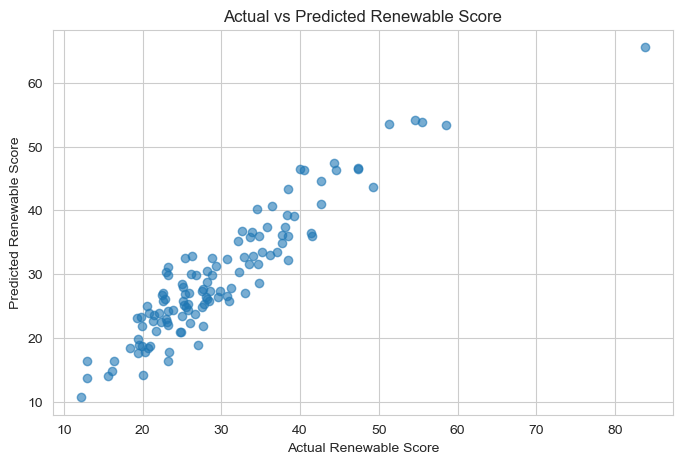

In [72]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel("Actual Renewable Score")
plt.ylabel("Predicted Renewable Score")
plt.title("Actual vs Predicted Renewable Score")
plt.grid(True)
plt.show()

In [73]:
feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=False)

feature_importance


avg_wind_speed       0.922069
annual_dni_value     0.035941
annual_ghi_value     0.022854
annual_tilt_value    0.019136
dtype: float64

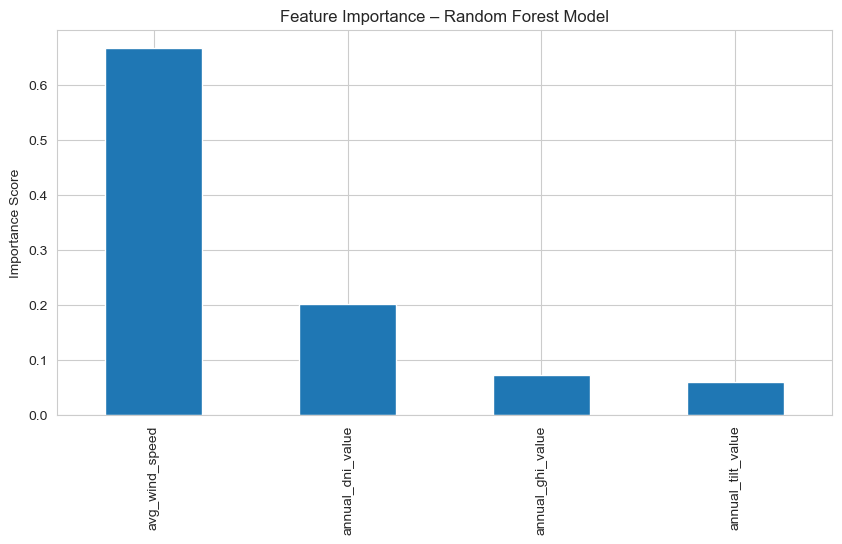

In [64]:
feature_importance.plot(kind='bar')
plt.title("Feature Importance – Random Forest Model")
plt.ylabel("Importance Score")
plt.show()